<a href="https://colab.research.google.com/github/itzThillaiC/Astronomical-image-denoiser/blob/main/SRGAN_model100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the required packages

In [2]:
import os
import random
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
IMAGES_PATH = '/content/drive/My Drive/Galaxy10/'
IMAGES = os.listdir(IMAGES_PATH)
random.shuffle(IMAGES)

In [4]:
len(IMAGES)

503

Assigning the device as cuda if GPU is available else cpu

In [5]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

Defining the generator architecture as given the reference paper

In [6]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

Assigning the Generator to cuda(if available) and printing the summary of the Generator with a dummy input

In [7]:
gen = Generator().to(cuda)

#Uncomment below mentioned three lines if you have more than one gpu and want to use all of them
#ngpu=2
# if (cuda.type == 'cuda') and (ngpu > 1):
#     gen = n.DataParallel(gen, list(range(ngpu)))
summary(gen,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

Defining the Discriminator network as given in the reference paper expect that a dropout in the last layer

In [8]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

Assigning the discriminator to the gpu(if available) and printing the summary of the network with a dummy value

In [9]:
disc = Discriminator().to(cuda)
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
            Conv2d-2         [-1, 64, 128, 128]          36,864
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
           Conv2d-10          [-1, 256, 32, 32]         589,824
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 512, 32, 32]       1,179,648
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
           Conv2d-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [10]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

Downloading the pretrained vgg19 model from model module of torchvision library

In [11]:
vgg = models.vgg19(pretrained=True).to(cuda)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Defining the losses to be used in training

In [12]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

Defining the adam optimizers for generator and discriminator

In [13]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

Loading the images after based on resizing as numpy array

In [14]:
def loadImages(IMAGES,path,resize=False):
    images=[]
    for image in (IMAGES):
#         print(image)
        if resize:
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256)) 
        else:
            img = cv2.imread(os.path.join(path,image))
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
#         print(img.shape)
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

Converting the high resolution images into low resolution by applying gaussian blur, resizing in to 64*64 and loading it as numpy array

In [15]:
def loadLRImages(IMAGES,path):
    images=[]
    for image in (IMAGES):
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        img = np.moveaxis(img, 2, 0)
        images.append(img)
    return np.array(images)

Loading the generator model from the given checkpoint

In [16]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

Given low resolution images and checkpoint, Generating the high resolution images out of it 

In [17]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
#     imagearray = (imagedir)/255
    # imagearrayPT = np.reshape(imagearray,(len(imagelist),imagearray.shape[3],imagearray.shape[1],imagearray.shape[2]))
    imagearrayPT = np.moveaxis(imagearray,3,1)
    # print(imagearrayPT.shape)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    # print(out_tensor.shape)
    # out = np.reshape(out_tensor,[out_tensor.shape[0],out_tensor.shape[2],out_tensor.shape[3],out_tensor.shape[1]])
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    # print(out.shape)
    out = np.clip(out,0,1)
    
    return out

Display utility of displaying images using matplotlib

In [18]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [19]:
#change the batch-size based on your system memory

epochs=100
batch_size=5

In [20]:
import os 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path =IMAGES_PATH
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

    
#LR_images_list = os.listdir(lr_path)
HR_images_list = IMAGES
batch_count = len(HR_images_list)//batch_size
batch_count

100

Starting of training and defining losses

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 60/60 [00:41<00:00,  1.46it/s]


Epoch ::::  1  d1_loss ::: 0.42849658626910475  d2_loss :::0.3990938818659439
genLoss ::: 7.707703568786383  vggLoss ::: 0.05218949690461159  MeanLoss  ::: 0.0034419937369724114


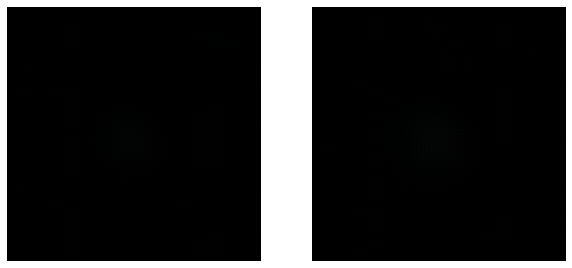

100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


Epoch ::::  2  d1_loss ::: 0.20226682606025592  d2_loss :::0.2172588551004992
genLoss ::: 12.327170221010844  vggLoss ::: 0.029512056273718675  MeanLoss  ::: 0.0014993392183290173


100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


Epoch ::::  3  d1_loss ::: 0.17432660082460716  d2_loss :::0.19583971509188178
genLoss ::: 16.70017864704132  vggLoss ::: 0.028158270101994277  MeanLoss  ::: 0.0012792696041287854


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  4  d1_loss ::: 0.3578429016355407  d2_loss :::0.34112571453764057
genLoss ::: 13.013860135028759  vggLoss ::: 0.025948843701432148  MeanLoss  ::: 0.0011121339441160672


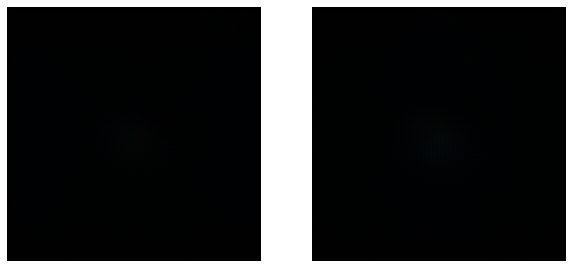

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  5  d1_loss ::: 0.28920136386754697  d2_loss :::0.2583893991712557
genLoss ::: 10.200456690788268  vggLoss ::: 0.022823467447112004  MeanLoss  ::: 0.0009794901896384544


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  6  d1_loss ::: 0.22819012921757054  d2_loss :::0.19414790075707192
genLoss ::: 15.19918794631958  vggLoss ::: 0.021052782842889427  MeanLoss  ::: 0.0009060003222354378


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  7  d1_loss ::: 0.27895665660488805  d2_loss :::0.26645352151250157
genLoss ::: 21.509354376792906  vggLoss ::: 0.020133083406835794  MeanLoss  ::: 0.0008621707122074441


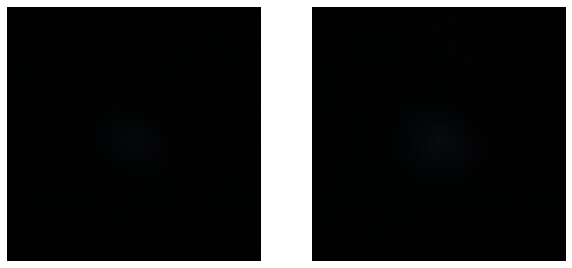

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  8  d1_loss ::: 0.19034371195092117  d2_loss :::0.1920098592670772
genLoss ::: 21.961500374476113  vggLoss ::: 0.01958694684629639  MeanLoss  ::: 0.0008250349928857759


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  9  d1_loss ::: 0.20387157178695253  d2_loss :::0.2581062635845616
genLoss ::: 25.817956733703614  vggLoss ::: 0.01922565808830162  MeanLoss  ::: 0.000790918764929908


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  10  d1_loss ::: 0.20657658160084544  d2_loss :::0.2536693909011564
genLoss ::: 24.611804286638897  vggLoss ::: 0.01894053042245408  MeanLoss  ::: 0.0007568631782002437


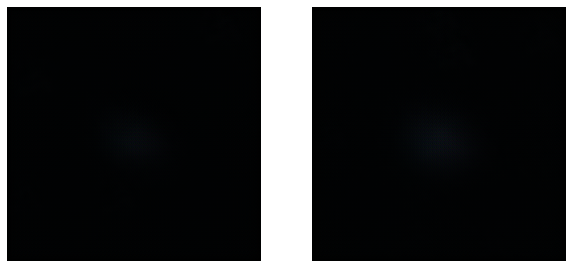

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  11  d1_loss ::: 0.19034911420520467  d2_loss :::0.23105570311440926
genLoss ::: 23.994914134343464  vggLoss ::: 0.01874026929338773  MeanLoss  ::: 0.0007238538916377971


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  12  d1_loss ::: 0.28000524510939934  d2_loss :::0.25522177795941353
genLoss ::: 23.545553982257843  vggLoss ::: 0.01855896917792658  MeanLoss  ::: 0.0006888252896411966


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  13  d1_loss ::: 0.24821694997753554  d2_loss :::0.3519959710500648
genLoss ::: 16.864759985605875  vggLoss ::: 0.01840529911375294  MeanLoss  ::: 0.0006600857566809281


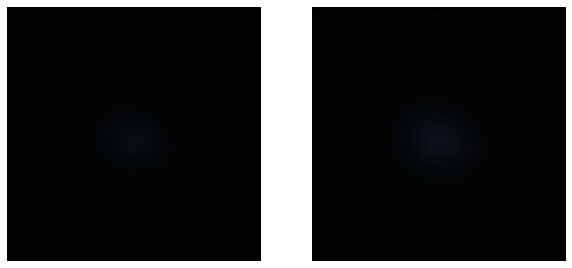

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  14  d1_loss ::: 0.23612065612019062  d2_loss :::0.2155570496058246
genLoss ::: 14.763474758466085  vggLoss ::: 0.018236803255664805  MeanLoss  ::: 0.0006349466251170573


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  15  d1_loss ::: 0.24253793294323775  d2_loss :::0.22619242890511704
genLoss ::: 17.526956518491108  vggLoss ::: 0.018105458972665172  MeanLoss  ::: 0.0006214900856624202


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  16  d1_loss ::: 0.2559137200103335  d2_loss :::0.34270181063564
genLoss ::: 20.312472649415334  vggLoss ::: 0.017992791440337896  MeanLoss  ::: 0.0006081052362181557


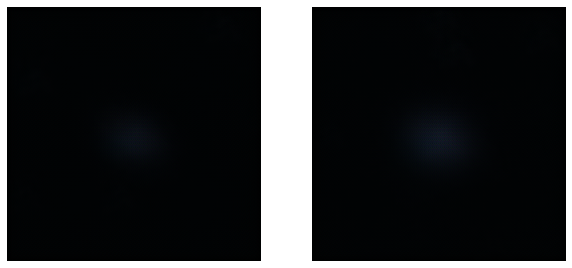

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  17  d1_loss ::: 0.9706791873801658  d2_loss :::0.23777642933590512
genLoss ::: 16.977918354670205  vggLoss ::: 0.01788760331304123  MeanLoss  ::: 0.0005946542233383904


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  18  d1_loss ::: 0.1889612269195157  d2_loss :::0.20268013869723278
genLoss ::: 22.352853894233704  vggLoss ::: 0.017796174917990962  MeanLoss  ::: 0.0005783516067216017


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  19  d1_loss ::: 0.20794421508908342  d2_loss :::0.23567008306582823
genLoss ::: 28.549500767389933  vggLoss ::: 0.0177127009180064  MeanLoss  ::: 0.0005652422029622054


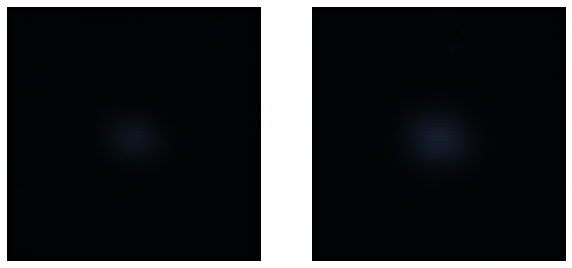

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  20  d1_loss ::: 0.18021829664710343  d2_loss :::0.22411920666694762
genLoss ::: 29.196275409062704  vggLoss ::: 0.017636222353515526  MeanLoss  ::: 0.000553586620662827


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  21  d1_loss ::: 0.20332357317568692  d2_loss :::0.2125666710237662
genLoss ::: 25.94303668340047  vggLoss ::: 0.017568515062642596  MeanLoss  ::: 0.0005421687004854902


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  22  d1_loss ::: 0.2102549796820408  d2_loss :::0.20332464476431458
genLoss ::: 24.96249030828476  vggLoss ::: 0.017497685660297673  MeanLoss  ::: 0.0005299643666755098


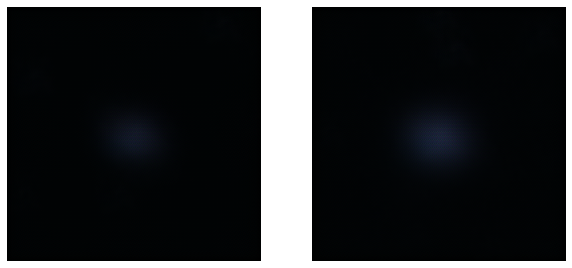

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  23  d1_loss ::: 0.18715266377181383  d2_loss :::0.2125651723146925
genLoss ::: 24.137363815307616  vggLoss ::: 0.017426794852750997  MeanLoss  ::: 0.0005138483713380993


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  24  d1_loss ::: 0.20102527696888567  d2_loss :::0.1871511785005025
genLoss ::: 23.17139115333557  vggLoss ::: 0.01734979609027505  MeanLoss  ::: 0.000499560940079391


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  25  d1_loss ::: 0.24264502848196726  d2_loss :::0.18021966670950268
genLoss ::: 19.614789120356242  vggLoss ::: 0.01727005996896575  MeanLoss  ::: 0.0004883850519642389


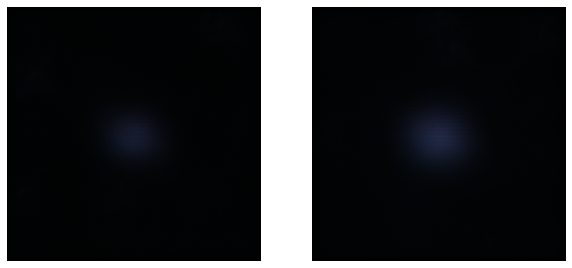

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  26  d1_loss ::: 0.2103529401571684  d2_loss :::0.18484060689807008
genLoss ::: 20.31986431280772  vggLoss ::: 0.017193623608909546  MeanLoss  ::: 0.0004723472501306484


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  27  d1_loss ::: 0.20569262484752096  d2_loss :::0.19408273567760376
genLoss ::: 21.259101239840188  vggLoss ::: 0.017123550362884998  MeanLoss  ::: 0.000457386826989629


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  28  d1_loss ::: 0.19409058084091854  d2_loss :::0.21025479078293324
genLoss ::: 21.135360383987425  vggLoss ::: 0.01704953096341342  MeanLoss  ::: 0.00044185164078953677


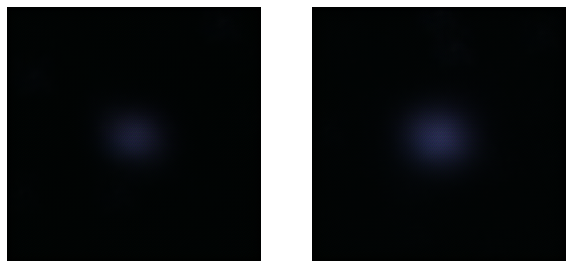

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  29  d1_loss ::: 0.23582245499136753  d2_loss :::0.19870245173695322
genLoss ::: 18.515931697686515  vggLoss ::: 0.016984549754609665  MeanLoss  ::: 0.00042245857014980477


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  30  d1_loss ::: 0.19870925426877914  d2_loss :::0.21257613768213907
genLoss ::: 21.600839440027872  vggLoss ::: 0.016923911147750915  MeanLoss  ::: 0.00040930523124795096


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  31  d1_loss ::: 0.21032062695018214  d2_loss :::0.19177690689498705
genLoss ::: 20.031430919965107  vggLoss ::: 0.016870515265812475  MeanLoss  ::: 0.0003989088955374124


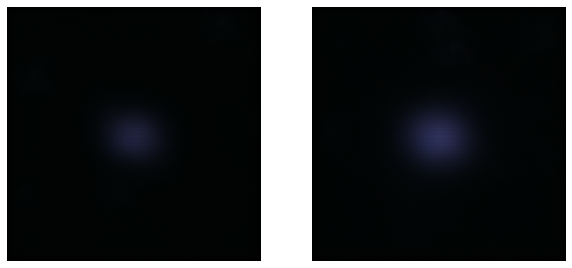

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  32  d1_loss ::: 0.24261076852685867  d2_loss :::0.2356771245286934
genLoss ::: 19.254972636699677  vggLoss ::: 0.016817994074275096  MeanLoss  ::: 0.00038947832266179226


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  33  d1_loss ::: 0.20102089936544046  d2_loss :::0.22411997855560672
genLoss ::: 20.501893496513368  vggLoss ::: 0.01676513747467349  MeanLoss  ::: 0.0003820579448074568


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  34  d1_loss ::: 0.18716453291717236  d2_loss :::0.1917775556166402
genLoss ::: 20.739852476119996  vggLoss ::: 0.01671412984530131  MeanLoss  ::: 0.00038036614472124105


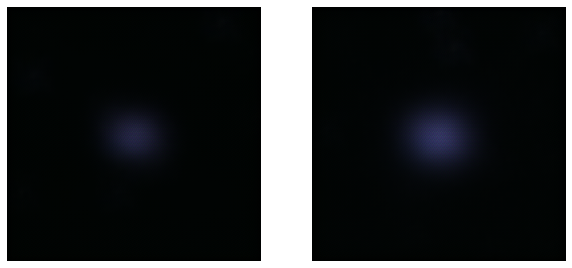

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  35  d1_loss ::: 0.21041279747732944  d2_loss :::0.19178095019784916
genLoss ::: 18.038026531537373  vggLoss ::: 0.016657296653526523  MeanLoss  ::: 0.0003733411598659586


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  36  d1_loss ::: 0.21949690267470412  d2_loss :::0.20572685969408883
genLoss ::: 22.159359033902486  vggLoss ::: 0.01660795050362746  MeanLoss  ::: 0.00036814834844941895


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  37  d1_loss ::: 0.19177638893327706  d2_loss :::0.2079684926645353
genLoss ::: 20.89821702639262  vggLoss ::: 0.01655496354214847  MeanLoss  ::: 0.00036273599519821197


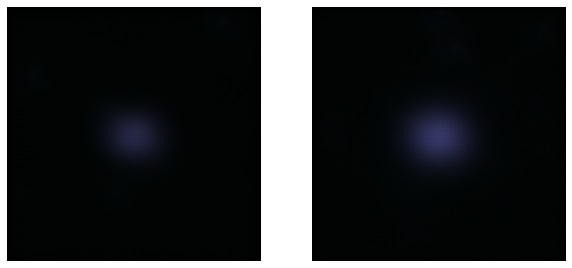

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  38  d1_loss ::: 0.21950638521912846  d2_loss :::0.17328904997454603
genLoss ::: 19.106017597516377  vggLoss ::: 0.016511913225986063  MeanLoss  ::: 0.00035972206921239074


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  39  d1_loss ::: 0.19179411451054307  d2_loss :::0.19177153920242576
genLoss ::: 20.308196965853373  vggLoss ::: 0.01646977066217611  MeanLoss  ::: 0.0003546200976416003


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  40  d1_loss ::: 0.20101915473701928  d2_loss :::0.2194992522508639
genLoss ::: 19.72212957541148  vggLoss ::: 0.01643045365344733  MeanLoss  ::: 0.00034830530445712307


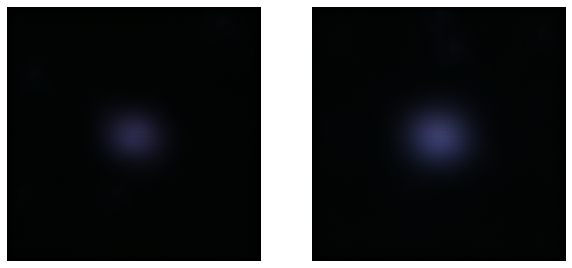

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  41  d1_loss ::: 0.21718774626699136  d2_loss :::0.2195031336898509
genLoss ::: 19.426942547162373  vggLoss ::: 0.016391812753863633  MeanLoss  ::: 0.00034181879891548306


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  42  d1_loss ::: 0.18484096974212597  d2_loss :::0.22642989682154469
genLoss ::: 20.31352073351542  vggLoss ::: 0.016352183480436603  MeanLoss  ::: 0.0003360550819100657


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  43  d1_loss ::: 0.21256872208736746  d2_loss :::0.21025865132682775
genLoss ::: 19.044109598795572  vggLoss ::: 0.016316198146281144  MeanLoss  ::: 0.0003311194139920796


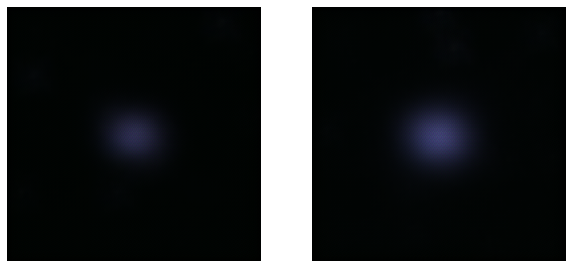

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  44  d1_loss ::: 0.19639847707274155  d2_loss :::0.18484301262581654
genLoss ::: 19.46101361910502  vggLoss ::: 0.016282308800145983  MeanLoss  ::: 0.00032722391673208523


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  45  d1_loss ::: 0.19870369841665927  d2_loss :::0.19639478439046956
genLoss ::: 19.15141187508901  vggLoss ::: 0.016250022097180288  MeanLoss  ::: 0.00032384259732983384


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  46  d1_loss ::: 0.22875292940298445  d2_loss :::0.22874248157847787
genLoss ::: 17.28921971321106  vggLoss ::: 0.016216405318118632  MeanLoss  ::: 0.00031950271368259565


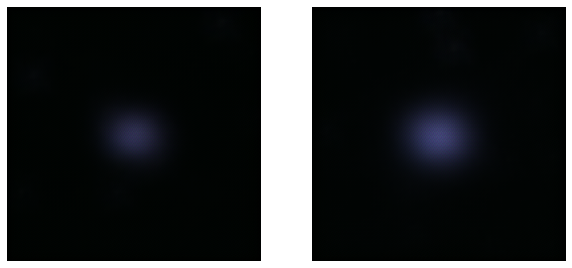

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  47  d1_loss ::: 0.21719781647820582  d2_loss :::0.23798395042951642
genLoss ::: 18.259833165009816  vggLoss ::: 0.016181323467753826  MeanLoss  ::: 0.0003164068031765055


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  48  d1_loss ::: 0.23567730914190205  d2_loss :::0.198709950861785
genLoss ::: 16.93558669090271  vggLoss ::: 0.01614754512750854  MeanLoss  ::: 0.00031301808267016897


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  49  d1_loss ::: 0.21950214248888114  d2_loss :::0.2102607911118151
genLoss ::: 17.872233605384828  vggLoss ::: 0.01611493017990142  MeanLoss  ::: 0.000310390900024989


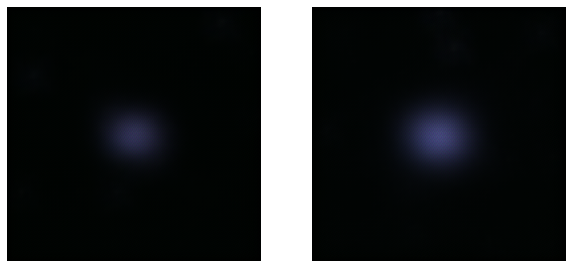

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  50  d1_loss ::: 0.20565126036736758  d2_loss :::0.20332991134663458
genLoss ::: 18.26819949944814  vggLoss ::: 0.016086236387491227  MeanLoss  ::: 0.0003079075390511813


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  51  d1_loss ::: 0.19408448894826905  d2_loss :::0.20101860316731612
genLoss ::: 19.332339453697205  vggLoss ::: 0.016057756380178034  MeanLoss  ::: 0.00030515203422207076


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  52  d1_loss ::: 0.20333920462350197  d2_loss :::0.20794937600601127
genLoss ::: 18.196405430634815  vggLoss ::: 0.016032173414714634  MeanLoss  ::: 0.0003015219035053936


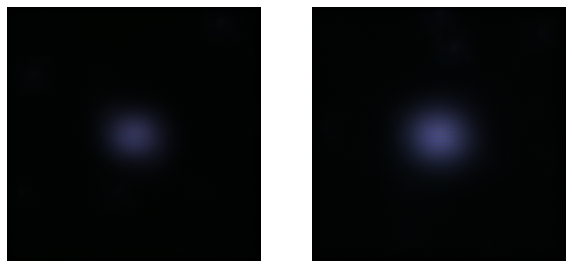

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  53  d1_loss ::: 0.2079500862531577  d2_loss :::0.21257329826359042
genLoss ::: 18.119580217202504  vggLoss ::: 0.01600527884438634  MeanLoss  ::: 0.0002979307408774427


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  54  d1_loss ::: 0.21256751325455286  d2_loss :::0.20794974642088396
genLoss ::: 17.93590575059255  vggLoss ::: 0.015977689491895337  MeanLoss  ::: 0.0002938712629353783


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  55  d1_loss ::: 0.21950681372264633  d2_loss :::0.2056366119218623
genLoss ::: 17.584572076797485  vggLoss ::: 0.015953111532144248  MeanLoss  ::: 0.000291623753097762


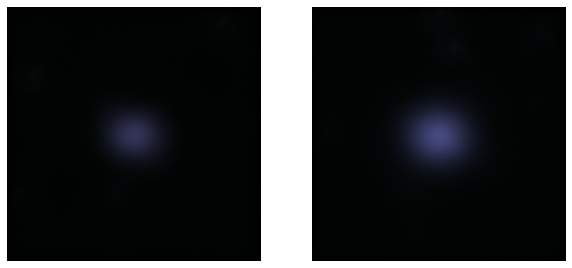

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  56  d1_loss ::: 0.24722985068790518  d2_loss :::0.22412430535774105
genLoss ::: 16.423647054036458  vggLoss ::: 0.0159289757333075  MeanLoss  ::: 0.0002883294716108746


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  57  d1_loss ::: 0.19408939789635846  d2_loss :::0.2125676046821695
genLoss ::: 18.952436606089275  vggLoss ::: 0.01590590022969991  MeanLoss  ::: 0.0002866499875381123


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  58  d1_loss ::: 0.21949742669887928  d2_loss :::0.2287444206885055
genLoss ::: 18.07134719689687  vggLoss ::: 0.015883278893306853  MeanLoss  ::: 0.0002853720533797362


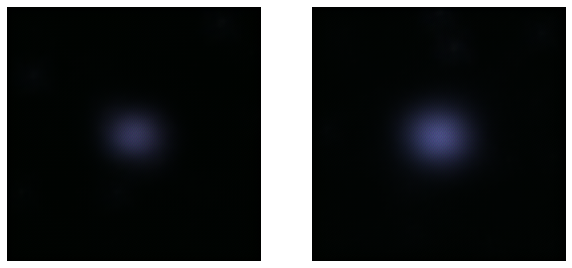

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  59  d1_loss ::: 0.21487970966894132  d2_loss :::0.21025665829758725
genLoss ::: 18.134453570842744  vggLoss ::: 0.015862405494165916  MeanLoss  ::: 0.00028339520892283566


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  60  d1_loss ::: 0.1594274887738013  d2_loss :::0.21487871419261276
genLoss ::: 20.086813696225484  vggLoss ::: 0.015839830172869065  MeanLoss  ::: 0.0002819475329791506


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  61  d1_loss ::: 0.2379817666384717  d2_loss :::0.189463889463576
genLoss ::: 17.168505438168843  vggLoss ::: 0.015819879272021352  MeanLoss  ::: 0.00028050544739623243


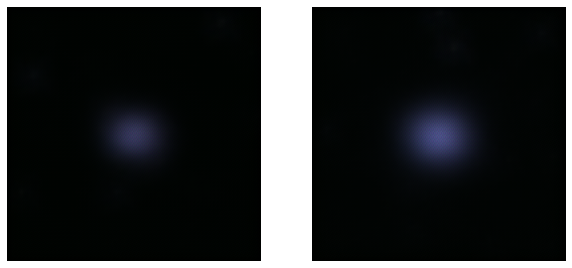

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  62  d1_loss ::: 0.23798250152522088  d2_loss :::0.18253073549588367
genLoss ::: 17.496288088957467  vggLoss ::: 0.015799090988002716  MeanLoss  ::: 0.00027913814434820473


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  63  d1_loss ::: 0.2148792020989198  d2_loss :::0.21718681504662432
genLoss ::: 18.28933399518331  vggLoss ::: 0.015779629326425494  MeanLoss  ::: 0.0002773182881355751


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  64  d1_loss ::: 0.21026077807018737  d2_loss :::0.2079469034260152
genLoss ::: 18.376569811503092  vggLoss ::: 0.015761076721052328  MeanLoss  ::: 0.0002762488482403569


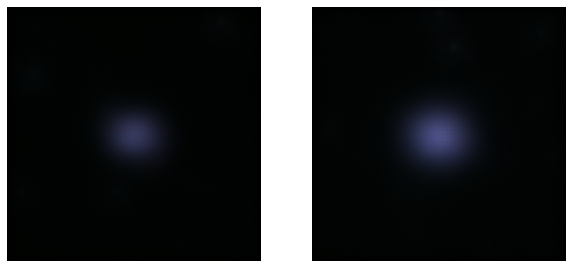

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  65  d1_loss ::: 0.20563933585309815  d2_loss :::0.19408435024318693
genLoss ::: 18.550408180554708  vggLoss ::: 0.015745277043121557  MeanLoss  ::: 0.00027526622943696566


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  66  d1_loss ::: 0.20332535446230987  d2_loss :::0.19408501774388845
genLoss ::: 18.91282327969869  vggLoss ::: 0.01573348018185546  MeanLoss  ::: 0.00027544274295602616


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  67  d1_loss ::: 0.20101842986877186  d2_loss :::0.21256708404155614
genLoss ::: 19.42327482700348  vggLoss ::: 0.015721251800035436  MeanLoss  ::: 0.00027574378448965337


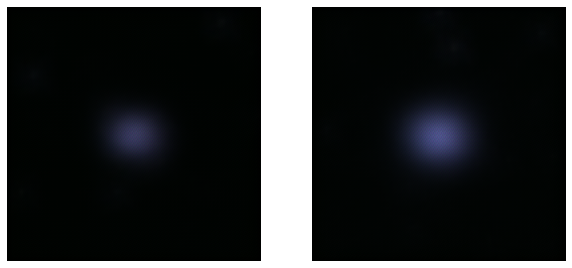

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  68  d1_loss ::: 0.18946132496510248  d2_loss :::0.1987053559405126
genLoss ::: 20.279017972946168  vggLoss ::: 0.015706826273041468  MeanLoss  ::: 0.00027512526115363776


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  69  d1_loss ::: 0.1987028553223202  d2_loss :::0.21718708659256242
genLoss ::: 19.374112606048584  vggLoss ::: 0.01568829344275097  MeanLoss  ::: 0.0002715424406536234


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  70  d1_loss ::: 0.21949692388376538  d2_loss :::0.2056344976041169
genLoss ::: 19.008704964319865  vggLoss ::: 0.0156696948222816  MeanLoss  ::: 0.00026751141607140504


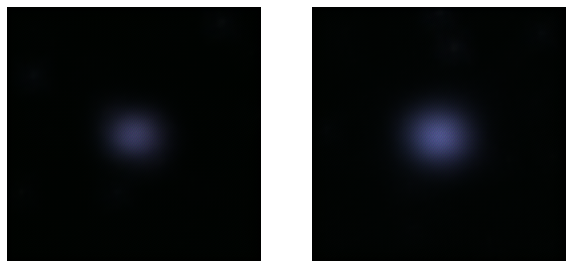

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  71  d1_loss ::: 0.21949761344887878  d2_loss :::0.214876498285893
genLoss ::: 18.88179202079773  vggLoss ::: 0.015651578681233028  MeanLoss  ::: 0.000265532188253322


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  72  d1_loss ::: 0.24953312829136884  d2_loss :::0.18021888673332434
genLoss ::: 18.207791447639465  vggLoss ::: 0.015634035730424028  MeanLoss  ::: 0.00026476311662311974


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  73  d1_loss ::: 0.17790858591599648  d2_loss :::0.18021881699610273
genLoss ::: 20.868062392870584  vggLoss ::: 0.01561947433122744  MeanLoss  ::: 0.000268346724139216


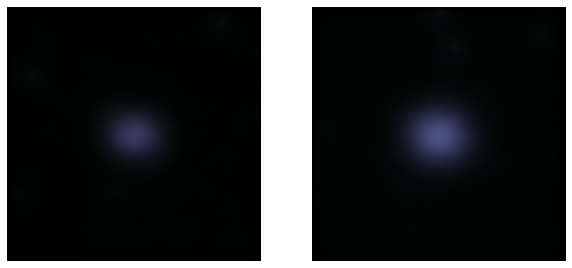

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  74  d1_loss ::: 0.23336029715977322  d2_loss :::0.2287390172483382
genLoss ::: 18.402824902534483  vggLoss ::: 0.015604052941004436  MeanLoss  ::: 0.0002707752918164867


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  75  d1_loss ::: 0.19177228882953776  d2_loss :::0.24953337108106327
genLoss ::: 19.330641158421834  vggLoss ::: 0.015594432937602203  MeanLoss  ::: 0.0002725255115365144


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  76  d1_loss ::: 0.19408512277658654  d2_loss :::0.20563514370278801
genLoss ::: 19.52019546031952  vggLoss ::: 0.015584794253421326  MeanLoss  ::: 0.00027555759055151915


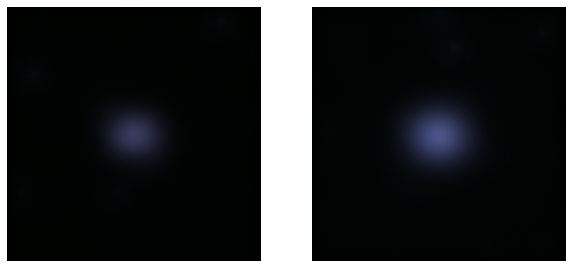

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  77  d1_loss ::: 0.21718636512761993  d2_loss :::0.17097727314240851
genLoss ::: 19.41795918146769  vggLoss ::: 0.015573171751263241  MeanLoss  ::: 0.00027712895462173037


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  78  d1_loss ::: 0.18946186651490363  d2_loss :::0.19870300139070807
genLoss ::: 19.754547174771627  vggLoss ::: 0.015555585346495112  MeanLoss  ::: 0.0002770416882412974


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  79  d1_loss ::: 0.2241194377519678  d2_loss :::0.20101351286033153
genLoss ::: 17.29597528775533  vggLoss ::: 0.01553818373940885  MeanLoss  ::: 0.00027677084338696055


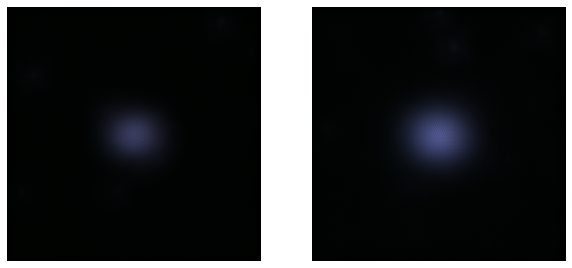

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  80  d1_loss ::: 0.2079459142235054  d2_loss :::0.21256668334628798
genLoss ::: 18.323456859588624  vggLoss ::: 0.015521245069491367  MeanLoss  ::: 0.0002755012896765644


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  81  d1_loss ::: 0.1825378671430191  d2_loss :::0.21487990376970836
genLoss ::: 21.304987168312074  vggLoss ::: 0.015506690973415971  MeanLoss  ::: 0.0002724686824270369


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  82  d1_loss ::: 0.20563401093190603  d2_loss :::0.18252953162186616
genLoss ::: 19.906497510274253  vggLoss ::: 0.015491075774965187  MeanLoss  ::: 0.00027005744996131396


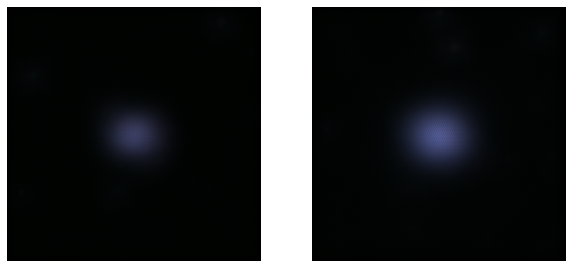

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  83  d1_loss ::: 0.2056342674791847  d2_loss :::0.18715050543677655
genLoss ::: 19.734362077713012  vggLoss ::: 0.01547517910754929  MeanLoss  ::: 0.00026778909596032464


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  84  d1_loss ::: 0.2079463997163972  d2_loss :::0.2171866721908323
genLoss ::: 19.325290203094482  vggLoss ::: 0.015463833953253925  MeanLoss  ::: 0.0002681273091487431


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  85  d1_loss ::: 0.2194967103004478  d2_loss :::0.20795284340797265
genLoss ::: 18.689072195688883  vggLoss ::: 0.015444907980660597  MeanLoss  ::: 0.0002686778905626852


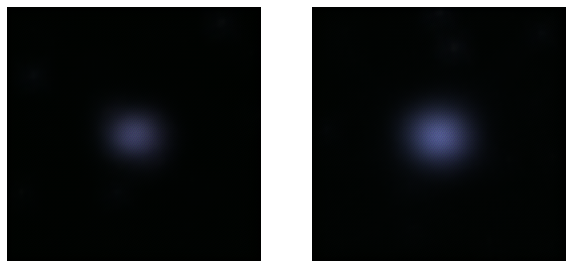

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  86  d1_loss ::: 0.2218370130668537  d2_loss :::0.1871817425786637
genLoss ::: 20.10922634601593  vggLoss ::: 0.015433520614169537  MeanLoss  ::: 0.0002669717105163727


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  87  d1_loss ::: 1.42384334385736  d2_loss :::0.5838288950423399
genLoss ::: 17.04995814139644  vggLoss ::: 0.015418840673131247  MeanLoss  ::: 0.00026815227368691316


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  88  d1_loss ::: 1.0285730493931813  d2_loss :::0.45210423992345267
genLoss ::: 6.361759247879188  vggLoss ::: 0.015403118908094864  MeanLoss  ::: 0.00026633270560220507


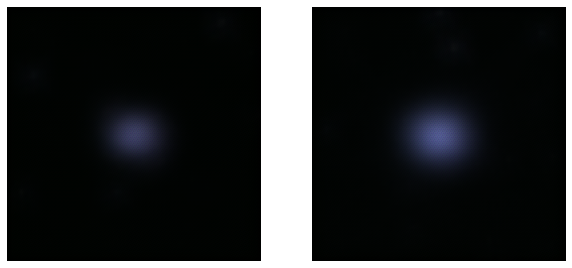

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  89  d1_loss ::: 0.22946091210378963  d2_loss :::0.23817393912112456
genLoss ::: 16.457802295684814  vggLoss ::: 0.015391765317569176  MeanLoss  ::: 0.00026479182415641846


100%|██████████| 60/60 [00:36<00:00,  1.62it/s]


Epoch ::::  90  d1_loss ::: 0.22428010948007682  d2_loss :::0.2194991002358444
genLoss ::: 20.9289470911026  vggLoss ::: 0.01537913753806303  MeanLoss  ::: 0.0002637615015070575


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  91  d1_loss ::: 0.2264331601628025  d2_loss :::0.20760168404467017
genLoss ::: 21.490245842933653  vggLoss ::: 0.015363964042626322  MeanLoss  ::: 0.00026307287686601436


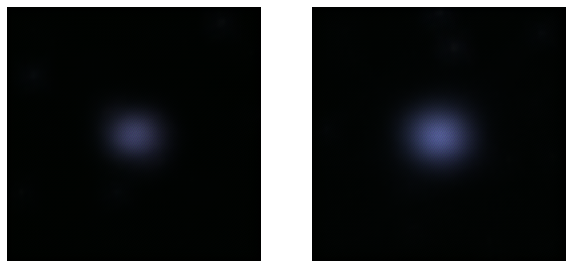

100%|██████████| 60/60 [00:36<00:00,  1.62it/s]


Epoch ::::  92  d1_loss ::: 0.18748977700310798  d2_loss :::0.22781935334515377
genLoss ::: 19.018887448310853  vggLoss ::: 0.0153457809627677  MeanLoss  ::: 0.0002624836072451823


100%|██████████| 60/60 [00:37<00:00,  1.62it/s]


Epoch ::::  93  d1_loss ::: 0.29294210667763015  d2_loss :::0.2803292573359999
genLoss ::: 20.302342995007834  vggLoss ::: 0.015328304291081925  MeanLoss  ::: 0.00026161480527662204


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  94  d1_loss ::: 0.2534068362186872  d2_loss :::0.23022364677933863
genLoss ::: 19.601099876562753  vggLoss ::: 0.015312035901782413  MeanLoss  ::: 0.0002624346200415554


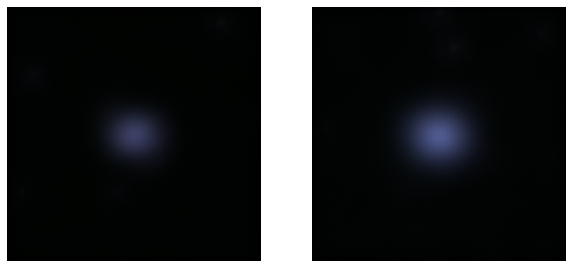

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  95  d1_loss ::: 0.20152532497452177  d2_loss :::0.2579692578316591
genLoss ::: 14.508717974026998  vggLoss ::: 0.015300717623904347  MeanLoss  ::: 0.0002635589689210368


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  96  d1_loss ::: 0.5523845168507397  d2_loss :::0.18797757818609853
genLoss ::: 22.264307045936583  vggLoss ::: 0.015289807016961277  MeanLoss  ::: 0.0002637539191103618


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  97  d1_loss ::: 0.5458985763788433  d2_loss :::0.1848467178645232
genLoss ::: 23.7023299296697  vggLoss ::: 0.015273432557781538  MeanLoss  ::: 0.0002630148253956577


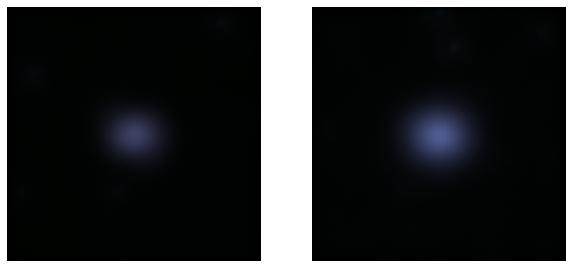

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  98  d1_loss ::: 0.5389671186606096  d2_loss :::0.22411763956149525
genLoss ::: 23.268698048591613  vggLoss ::: 0.015257983895329138  MeanLoss  ::: 0.00026141732353911115


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  99  d1_loss ::: 0.5666930645704269  d2_loss :::0.2171867503807036
genLoss ::: 22.036135101318358  vggLoss ::: 0.01524294853831331  MeanLoss  ::: 0.00025997871792545385


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  100  d1_loss ::: 0.5389671945617011  d2_loss :::0.2125656820833683
genLoss ::: 23.460867579778036  vggLoss ::: 0.015232442234021922  MeanLoss  ::: 0.00025902758752636144


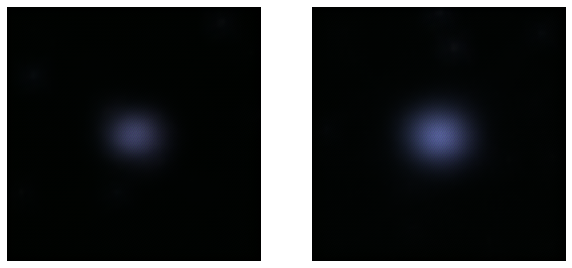

In [21]:
batch_count=60
import torch
torch.cuda.empty_cache()
for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
     

    
    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255
        
                
        disc.zero_grad()

        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        # d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        # print(d1_loss,d2_loss)
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()
        

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())
        
        generator_loss = g_loss + v_loss + m_loss
        # v_loss.backward(retain_graph=True)
        # m_loss.backward(retain_graph=True)
        # g_loss.backward()
        # print(generator_loss)

        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

        
        
#         print("d1Loss ::: "+str((d1_loss.item()))+" d2Loss ::: "+str((d2_loss.item())))
#         print("gloss ::: "+str((g_loss.item()))+" vloss ::: "+str((v_loss.item()))+" mloss ::: "+str((m_loss.item())))
    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        out_images = imagePostProcess(IMAGES[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
#         print(out_images.shape)
#         test_images = loadLRImages(images[:-3],hr_path)/255
#         test_images = np.reshape(test_images,(test_images[0],test_images.shape[3],test_images.shape[1],test_images.shape[2]))
#         out_images = gen(torch.from_numpy(test_images).to(cuda).float())
#         out_images = np.reshape(out_images,(out_images[0],out_images[2],out_images[3],out_images[1]))
        show_samples(out_images)
        